# Literature Search

Here we will explore the prevalence of different measures of aperiodic activity in the literature.

To do so, we will use [LISC](https://github.com/lisc-tools/lisc), a Python module for collecting and analyzing scientific literature. More information on LISC can be found in the [documentation](https://lisc-tools.github.io/lisc/).

To explore the prevalence and use cases of aperiodic measures, we will collect information from the Pubmed database on the number of papers that include search terms mentioning aperiodic measures, as well as the number of papers that mention these terms of interest in co-occurrence with specified association terms.

Note that collecting literature data in this way is likely an under-estimate of the use of these measures, as the approach employed here only searches for search terms occurring in titles and abstracts.

In [1]:
# Setup notebook state
from nbutils import setup_notebook; setup_notebook()

In [2]:
import seaborn as sns

In [3]:
# Import LISC code for literature collection & analysis
from lisc import Counts, Counts1D
from lisc.collect import collect_info, collect_across_time
from lisc.io import (save_meta_data, load_meta_data, save_object, load_object,
                     save_time_results, load_time_results)
from lisc.plts.counts import plot_matrix, plot_vector
from lisc.plts.time import plot_results_across_years

In [4]:
# Import custom project code
from apm.io import APMDB
from apm.plts.utils import figsaver

## Settings

First, we will define some settings for the literature collection.

In [5]:
# Settings for literature collection
db = 'pubmed'

In [6]:
# Notebook settings
RUN_COLLECTION = False
SAVE_DATA = False

In [7]:
# File path settings
db = APMDB()

In [8]:
# Settings for saving figures
SAVE_FIG = False
FIGPATH = db.figs_path / '02_literature'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH, directory=True)

## Define Terms

Here we will define search terms to use to collect information on the literature of interest. 

### Search Terms

First, we will define the search terms that reflect our terms of interest.

Note that each set of terms within a list is a defined as a set of synonyms

In [9]:
# Set list of aperiodic terms & labels
concept_terms = [
    ['aperiodic', 'arrythmic'],
    ['1/f', '1/f-like', 'one-over f'],
    ['scale free', 'fractal'],
    ['criticality', 'complex dynamics'],
    ['chaos', 'dynamical system'],
    ['neural noise'],
]
concept_labels = ['aperiodic', '1/f', 'scale free', 'criticality', 'chaos', 'neural noise']
assert len(concept_terms) == len(concept_labels)

In [10]:
# Set list of aperiodic method categories & labels
method_terms = [
    ['autocorrelation'],
    ['dfa', 'detrended fluctuation analysis', 'hurst exponent'],
    ['fractal', 'correlation dimension', 'higuchi', 'katz', 'petrosian'],
    ['complexity'],
    ['entropy', 'information theory'],
    ['spectral parameterization', 'fooof', 'irasa', 'cgsa', 'aperiodic exponent',
     'spectral slope', 'spectral exponent', 'powerlaw decay'],
]
method_labels = ['autocorrelation', 'fluctuation', 'fractal', 'complexity', 'entropy', 'exponent']
assert len(method_terms) == len(method_labels)

In [11]:
# Set list of specific measures
measure_terms = [
    # Autocorrelation measures
    ['autocorrelation'],
    ['autocorrelation decay', 'decorrelation time', 'autocorrelation timescale',
     'autocorrelation window', 'autocorrelation width'],
    # Fluctuation measures
    ['hurst exponent'],
    ['detrended fluctuation analysis', 'dfa', 'scaling exponent'],
    ['multiscale dfa', 'multiscale detrended fluctuation analysis', 
     'multifractal dfa', 'multifractal detrended fluctuation analysis', 
     'mfdfa', 'multiscale multifractal analysis'],
    # Fractal dimension measures
    ['correlation dimension'],
    ['higuchi fractal dimension', 'higuchi dimension'],
    ['katz fractal dimension', 'katz dimension'],
    ['petrosian fractal dimension', 'petrosian dimension'],
    # Complexity measures
    ['hjorth complexity', 'hjorth'],
    ['lempel-ziv complexity', 'LZ complexity'],
    ['lyapunov exponent', 'lyapunov exponents'],
    # Entropy measures
    ['approximate entropy'],
    ['sample entropy'],
    ['permutation entropy'],
    ['weighted permutation entropy'],
    ['spectral entropy'],
    ['multiscale entropy'],
    # Aperiodic exponent measures
    ['irasa', 'irregular resampling auto-spectral analysis', 'fractal component'],
    ['specparam', 'spectral parameterization', 'fooof', 'fitting oscillations and one-over f',
     'spectral slope', 'spectral exponent', 'powerlaw decay'],
]

### Inclusion / Exclusion Terms

In some cases, we might want to use additional search terms to explicit include or exclude results that contain particular terms. 

These terms can be used to restrict searches to literature of interest, excluding irrelevant literature. 

In [12]:
# Set inclusion / exclusion terms
inclusions = [
    'EEG', 'electroencephalography',
    'MEG', 'magnetoencephalography',
    'ECoG', 'electrocorticography',
    'iEEG', 'intracranial EEG',
    'LFP', 'local field potential',
]

exclusions = ['lithium']

In [13]:
# Define a list of association terms
assoc_terms = [
    ['aging', 'age-related', 'development'],
    ['sleep', 'anesthesia', 'consciousness', 'brain states', 'coma'],
    ['cognitive', 'cognition', 'task', 'behavior', 'experiment', 'perception', 'memory'],
    ['seizure', 'epilepsy', 'ictal', 'interictal'],
    ['clinical', 'disorder', 'psychopathology', 'psychiatry', 'diagnose',
     'mental illness', 'biomarker', 'pathophysiology', 'disease'],
]

### Collect terms

In [14]:
# Collect all terms together
concept_terms_dict = {
    'terms' : concept_terms,
    'labels' : concept_labels,
    'inclusions' : [inclusions] * len(concept_terms),
    'exclusions' : [exclusions] * len(concept_terms),
}

method_terms_dict = {
    'terms' : method_terms,
    'labels' : method_labels,
    'inclusions' : [inclusions] * len(method_terms),
    'exclusions' : [exclusions] * len(method_terms),
}

measure_terms_dict = {
    'terms' : measure_terms,
    'inclusions' : [inclusions] * len(measure_terms),
    'exclusions' : [exclusions] * len(measure_terms),
}

## Run a Metadata Check

In [15]:
if RUN_COLLECTION:
    meta_data = collect_info()
    if SAVE_DATA:
        save_meta_data(meta_data, 'meta_data', db.literature_path)

else:
    meta_data = load_meta_data('meta_data', db.literature_path)

In [16]:
# Check the meta data for the collection
meta_data

{'date': '2024-08-31_23:05:22', 'log': None, 'requester_n_requests': 1, 'requester_wait_time': 0.3333333333333333, 'requester_start_time': '23:05:22 Saturday 31 August 2024', 'requester_end_time': '23:05:22 Saturday 31 August 2024', 'requester_logging': None, 'db_info_dbname': 'pubmed', 'db_info_menuname': 'PubMed', 'db_info_description': 'PubMed bibliographic record', 'db_info_dbbuild': 'Build-2024.08.31.10.21', 'db_info_count': '37683730', 'db_info_lastupdate': '2024/08/31 10:21'}

## Add & Check Terms

Now we can add these terms to LISC objects, ready for data collection. 

In [17]:
# Initialize & add terms to the LISC object - concepts
counts_concepts = Counts()
counts_concepts.add_terms(concept_terms_dict, dim='A')
counts_concepts.add_terms(assoc_terms, dim='B')

In [18]:
# Initialize & add terms to the LISC object - methods
counts_methods = Counts()
counts_methods.add_terms(method_terms_dict, dim='A')
counts_methods.add_terms(assoc_terms, dim='B')

In [19]:
# Initialize & add terms to the LISC object - measures (no associations)
counts_measures = Counts1D()
counts_measures.add_terms(measure_terms_dict)

In [20]:
# Check terms - concepts
counts_concepts.terms['A'].check_terms()

List of terms used: 

aperiodic     : aperiodic, arrythmic
1/f           : 1/f, 1/f-like, one-over f
scale free    : scale free, fractal
criticality   : criticality, complex dynamics
chaos         : chaos, dynamical system
neural noise  : neural noise


In [21]:
# Check terms - methods
counts_methods.terms['A'].check_terms()

List of terms used: 

autocorrelation  : autocorrelation
fluctuation      : dfa, detrended fluctuation analysis, hurst exponent
fractal          : fractal, correlation dimension, higuchi, katz, petrosian
complexity       : complexity
entropy          : entropy, information theory
exponent         : spectral parameterization, fooof, irasa, cgsa, aperiodic exponent, spectral slope, spectral exponent, powerlaw decay


In [22]:
# Check terms - measures
counts_measures.check_terms()

List of terms used: 

autocorrelation                 : autocorrelation
autocorrelation decay           : autocorrelation decay, decorrelation time, autocorrelation timescale, autocorrelation window, autocorrelation width
hurst exponent                  : hurst exponent
detrended fluctuation analysis  : detrended fluctuation analysis, dfa, scaling exponent
multiscale dfa                  : multiscale dfa, multiscale detrended fluctuation analysis, multifractal dfa, multifractal detrended fluctuation analysis, mfdfa, multiscale multifractal analysis
correlation dimension           : correlation dimension
higuchi fractal dimension       : higuchi fractal dimension, higuchi dimension
katz fractal dimension          : katz fractal dimension, katz dimension
petrosian fractal dimension     : petrosian fractal dimension, petrosian dimension
hjorth complexity               : hjorth complexity, hjorth
lempel-ziv complexity           : lempel-ziv complexity, LZ complexity
lyapunov exponent      

In [23]:
# Check terms - associations
counts_concepts.terms['B'].check_terms()

List of terms used: 

aging      : aging, age-related, development
sleep      : sleep, anesthesia, consciousness, brain states, coma
cognitive  : cognitive, cognition, task, behavior, experiment, perception, memory
seizure    : seizure, epilepsy, ictal, interictal
clinical   : clinical, disorder, psychopathology, psychiatry, diagnose, mental illness, biomarker, pathophysiology, disease


## Collect Literature Data

Run literature collection. 

In [24]:
# Run the data collection
if RUN_COLLECTION:
    counts_concepts.run_collection(db=db)
    counts_methods.run_collection(db=db)
    counts_measures.run_collection(db=db)
else:
    counts_concepts = load_object('counts_concepts.p', directory=db.literature_path)
    counts_methods = load_object('counts_methods.p', directory=db.literature_path)
    counts_measures = load_object('counts_measures.p', directory=db.literature_path)

## Check and Process Collected Data

Now we can examine the collected literature data.

In [25]:
# Check how many papers were found for each term (concepts)
counts_concepts.check_counts()

The number of documents found for each search term is:
  'aperiodic'      -   287
  '1/f'            -   239
  'scale free'     -   552
  'criticality'    -   158
  'chaos'          -   254
  'neural noise'   -    51


In [26]:
# Check how many papers were found for each term (methods)
counts_methods.check_counts()

The number of documents found for each search term is:
  'autocorrelation'   -    171
  'fluctuation'       -    245
  'fractal'           -    650
  'complexity'        -   2777
  'entropy'           -   2292
  'exponent'          -    135


In [27]:
# Check how many papers were found for each term (measures)
counts_measures.check_counts()

The number of documents found for each search term is:
  'autocorrelation'                  -   171
  'autocorrelation decay'            -    16
  'hurst exponent'                   -    73
  'detrended fluctuation analysis'   -   195
  'multiscale dfa'                   -    20
  'correlation dimension'            -   221
  'higuchi fractal dimension'        -    48
  'katz fractal dimension'           -    30
  'petrosian fractal dimension'      -     9
  'hjorth complexity'                -   126
  'lempel-ziv complexity'            -   175
  'lyapunov exponent'                -   146
  'approximate entropy'              -   272
  'sample entropy'                   -   332
  'permutation entropy'              -   180
  'weighted permutation entropy'     -     8
  'spectral entropy'                 -   227
  'multiscale entropy'               -   176
  'irasa'                            -    15
  'specparam'                        -    99


In [28]:
# Check the total number of papers across all terms
print('Total number of aperiodic papers (concepts): \t',
      sum(counts_concepts.terms['A'].counts))
print('Total number of aperiodic papers (methods): \t',
      sum(counts_methods.terms['A'].counts))
print('Total number of aperiodic papers (measures): \t',
      sum(counts_measures.counts))

Total number of aperiodic papers (concepts): 	 1541
Total number of aperiodic papers (methods): 	 6270
Total number of aperiodic papers (measures): 	 2539


In [29]:
# Normalize the association results
counts_concepts.compute_score('normalize', dim='A')
counts_methods.compute_score('normalize', dim='A')

## Create Visualizations of Collected Data

### Concepts

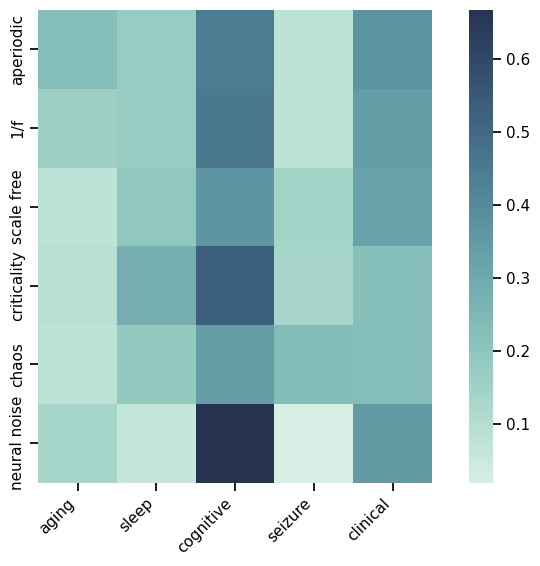

In [30]:
# Plot the associations of aperiodic measures in the literature
plot_matrix(counts_concepts.score, counts_concepts.terms['B'].labels,
            counts_concepts.terms['A'].labels, cmap='blue', square=True,
            xtickrotation=45, figsize=(8, 6), **fsaver('lit_counts_concepts'))

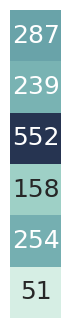

In [31]:
# Plot the number of papers found per concept term
plot_vector(counts_concepts, cmap='blue', figsize=(1.5, 4), **fsaver('total_counts_concepts'))

### Methods

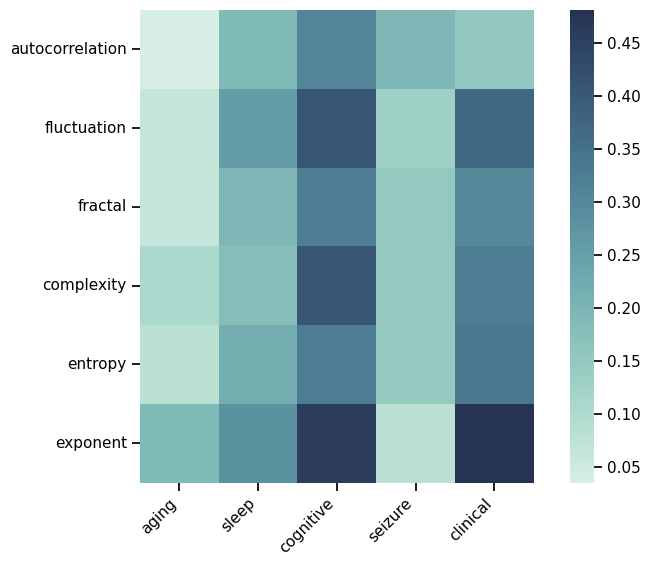

In [32]:
# Plot the associations of aperiodic measures in the literature
plot_matrix(counts_methods.score, counts_methods.terms['B'].labels,
            counts_methods.terms['A'].labels, cmap='blue', square=True,
            xtickrotation=45, figsize=(8, 6), **fsaver('lit_counts_methods'))

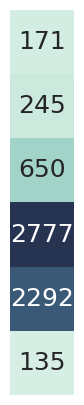

In [33]:
# Plot the number of papers found per methods measure
plot_vector(counts_methods, cmap='blue', figsize=(2, 5), **fsaver('total_counts_methods'))

### Measures

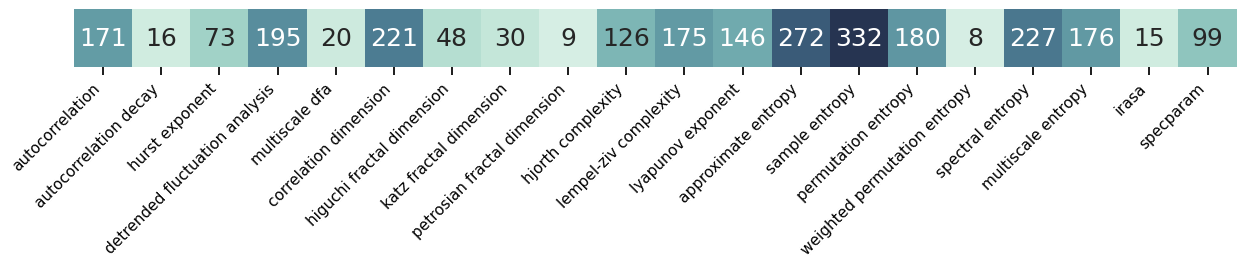

In [34]:
# Plot the number of papers found per measure
with sns.plotting_context('notebook'):
    plot_vector(counts_measures, labels=counts_measures.labels, cmap='blue',
                transpose=True, xtickrotation=45, figsize=(15, 1.5),
                **fsaver('total_counts_measures'))

In [35]:
# Save out the collected data
if SAVE_DATA:
    save_object(counts_concepts, 'counts_concepts', directory=db.literature_path)
    save_object(counts_methods, 'counts_methods', directory=db.literature_path)
    save_object(counts_measures, 'counts_measures', directory=db.literature_path)

## Examine Literature Terms over Time


In [36]:
# Define range of years to collect data for
start_year, end_year = 1960, 2024
years = list(range(start_year, end_year + 1))

In [37]:
# Collect count of the number of aperiodic related papers per year
if RUN_COLLECTION:
    
    # Setup object and run time collecting - concepts
    years_concepts = Counts1D()
    years_concepts.add_terms(concept_terms_dict)
    years_concept_results = collect_across_time(years_concepts, years)

    # Setup object and run time collecting - methods
    years_methods = Counts1D()
    years_methods.add_terms(method_terms_dict)
    years_method_results = collect_across_time(years_methods, years)

    if SAVE_DATA:
        save_time_results(years_concept_results, 'time_concepts', 'concepts', db.literature_path)
        save_time_results(years_method_results, 'time_methods', 'methods', db.literature_path)

else:
    years_concept_results = load_time_results('time_concepts', 'concepts', directory=db.literature_path)
    years_method_results = load_time_results('time_methods', 'methods', directory=db.literature_path)

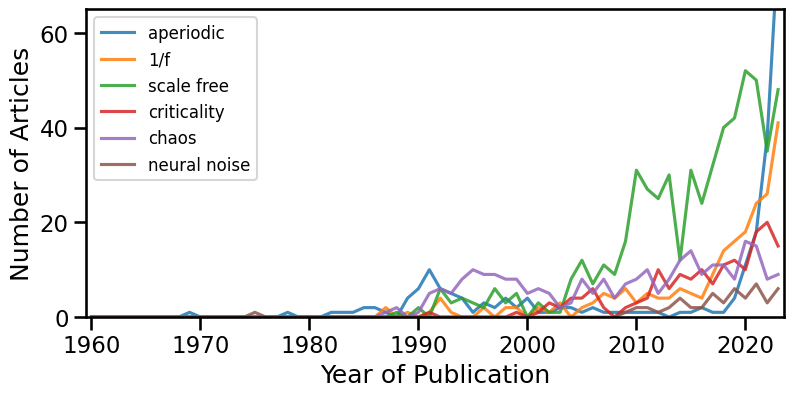

In [38]:
# Plot the results over time of the concept results
plot_results_across_years(years_concept_results, xlim=[1959.5, 2023.5], ylim=[0, 65],
                          figsize=(9, 4), **fsaver('years_concepts'))

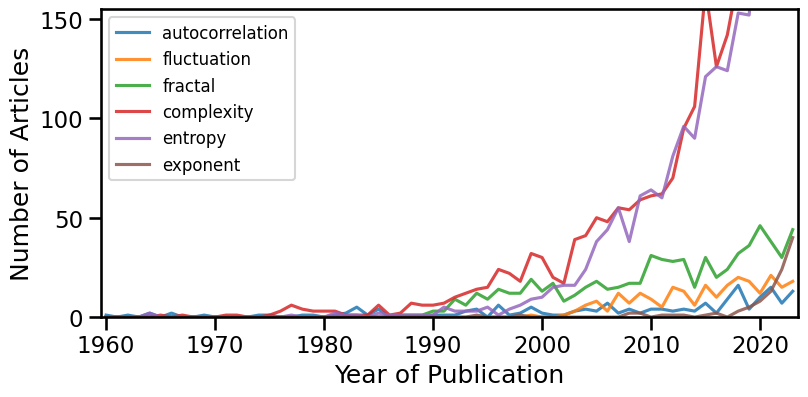

In [39]:
# Plot the results over time of the method results
plot_results_across_years(years_method_results, xlim=[1959.5, 2023.5], ylim=[0, 155],
                          figsize=(9, 4), **fsaver('years_methods'))